<a href="https://colab.research.google.com/github/bhavikar04/first-GAN/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# project

Use the "Run" button to execute the code.

In [ ]:
#pip install wget, tqdm
!pip install opendatasets --upgrade --quiet
import opendatasets as od

Downloading the dataset:

I tried using the wget module at first , but since it doesn't support datasets that require authentication, I switched to the requests module.


In [ ]:
!pip install requests
import requests
url = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/faces.tar.gz'
auth1 = ('adiencedb', 'adience')

dataset_ = requests.get(url, auth = auth1)

I have used the FDF dataset of faces of different ages and genders by exposing.ai . Here's some info about the dataset :

Total number of photos: 26,580

Total number of subjects: 2,284

Number of age groups / labels: 8 (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)

Gender labels: Yes

In the wild: Yes

Subject labels: Yes

In [ ]:
#print(dataset_[:10])
images = dataset_.content
print(images[:10])

b'\x1f\x8b\x08\x00\xcd@\xa1S\x00\x03'


Importing some necessary libraries that we will be using.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

Somehow modifying the dataset and loading it into data loaders turned out to be the most cumbersome part of the project for me. Perhaps because I didn't know what a tarfile was (chatgpt to the rescue :p)

In [ ]:
!pip install zipfile
if dataset_.status_code == 200:
 with open('faces.tar.gz', 'wb') as f:
  f.write(dataset_.content)



ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [ ]:
!pip install tarfile
import tarfile
if dataset_.status_code == 200:
  with tarfile.open('faces.tar.gz', 'r:gz') as tar:
        tar.extractall('/content/faces')

  transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  dataset_ = ImageFolder(root='/content/faces/faces', transform=transform)



ERROR: Could not find a version that satisfies the requirement tarfile (from versions: none)
ERROR: No matching distribution found for tarfile


Next, we make modifications to the dataset. The ImageFolder class is used to load a dataset of images from a directory. The first argument to the ImageFolder class is the path to the directory containing the images. The second argument is the transform, which is a sequence of operations that are applied to each image in the dataset.



In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder('/content/faces', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We are using torchvision.transorm here to apply the necessary changes to each image.The transform in this case consists of four operations:

Resize: This operation resizes each image to the specified size (64 pixels in this case).
CenterCrop: This operation crops the center of each image to the specified size.

ToTensor: This operation converts each image to a tensor.

Normalize: This operation normalizes each image by subtracting the mean (0.5,0.5,0.5) and dividing by the standard deviation (0.5,0.5,0.5).The pixel values are now centred around 0 and have a standard deviation of 1.

We then proceed to load the images onto the training dataloaders.

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='project', environment=None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

Showing you a small sample of the dataset and the kind of images it has. The image tensors have been denormalised to their original state.

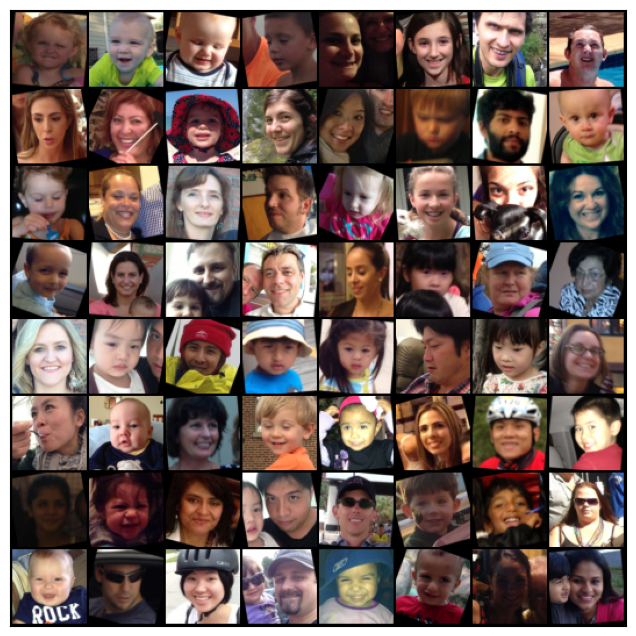

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, axes = plt.subplots(figsize=(8, 8))
    axes.set_xticks([]); axes.set_yticks([])
    axes.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
print(device)

cuda


Since I made the project on colab, I had access to a gpu (cuda).In the above code snippet, we simply moved the images onto the gpu.

Now coming to the actual 'GAN' part of the code, we make the discriminator network. The role of the discriminator will be to classify images as real or fake. For now we define the network as a series of convolutional layers.We transform the input from 3x64x64 to 1x1x1 tensors.

In [ ]:
import torch.nn as nn

disc = nn.Sequential(
#Layer1
nn.Conv2d(3,64,stride = 2, kernel_size = 4, padding = 1, bias= False),
nn.BatchNorm2d(64),
nn.LeakyReLU(0.2,inplace = True),

#Layer2
nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(128),
nn.LeakyReLU(0.2, inplace=True),

#Layer3
nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(256),
nn.LeakyReLU(0.2, inplace=True),

#Layer4
nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(512),
nn.LeakyReLU(0.2, inplace=True),
# out: 512 x 4 x 4

nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
# 1x1x1 output

nn.Flatten() ,#to get a 1d vector as output
nn.Sigmoid() #to get a value between 0 and 1 as output
)

disc = to_device(disc, device)


In [ ]:
latent_size =128

Next, we make the generator network. The job of the generator is to 'generate' images from tensors. The does the exact opposite and converts the tensor values to 64x64 pixel grids.(3 channels of course)

In [ ]:
gen = nn.Sequential(
#1st layer
nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


In [ ]:

#batch_size = 64

torch.Size([128, 3, 64, 64])


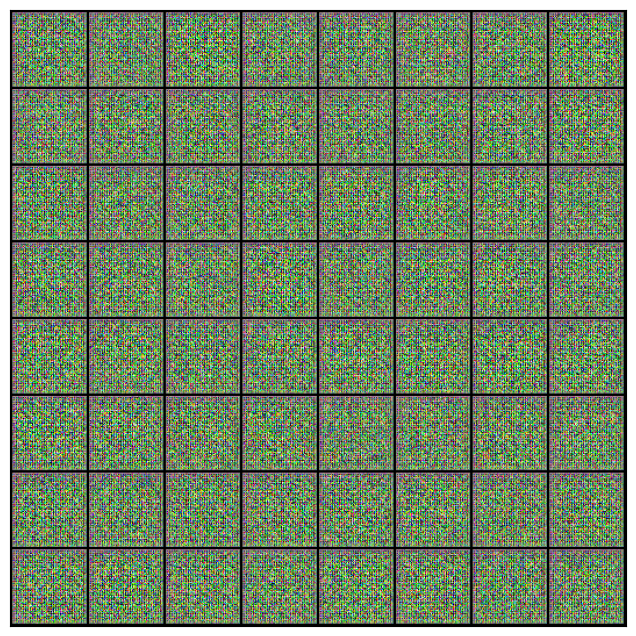

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # initialising random latent tensors
fake_images = gen(xb)
print(fake_images.shape)
show_images(fake_images)
#The images we get when the generator hasn't been trained.

In [ ]:
gen = to_device(gen,device)

Training the discriminator

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

We create the train function for the discriminator here, to assign value '1' for images that are real and '0' for the fake ones.

In [ ]:
def train_disc(imgs, opt_d):

    opt_d.zero_grad()

    preds_r = disc(imgs)
    targets_r = torch.ones(imgs.size(0), 1,device=device)
    loss_r = F.binary_cross_entropy(preds_r,targets_r)
    mean_score = torch.mean(preds_r).item()

    latent = torch.randn(batch_size,latent_size,1,1,device= device) #initialising the latent space with random values
    fakes = gen(latent)
    # Pass fake images through discriminator
    preds_f = disc(fakes)
    targets_f = torch.zeros(fakes.size(0), 1, device=device)
    loss_f = F.binary_cross_entropy(preds_f, targets_f)
    fakes_score = torch.mean(preds_f).item()

    # Update discriminator weights
    loss = loss_r + loss_f
    loss.backward()
    opt_d.step()
    return loss.item(), mean_score, fakes_score


Training function for the generator.
We pass a bunch of generated images through the discriminator and store it's predictions. Now to train the generator, we calculate the loss value between the predictions of the discriminator and the targets- which have all been set to 1. Thus , we are trying to make the generator better at fooling the discriminator i.e make its images like the ones the discriminator has been trained on.

In [ ]:
def train_gen(opt_g):

    opt_g.zero_grad()


    latent = torch.randn(batch_size,latent_size,1,1,device= device) #initialising the latent space with random values
    fakes = gen(latent)
    # Pass fake images through discriminator
    preds_f = disc(fakes)
    #however this time, we will set targets as 1 i.e real
    targets_f = torch.ones(fakes.size(0), 1, device=device)
    loss_f = F.binary_cross_entropy(preds_f, targets_f)
    fakes_score = torch.mean(preds_f).item()

    # Update generator weights
    loss_f.backward()
    opt_g.step()
    return loss_f.item(),fakes_score


This is where the magic happens ! We train both the generator and the discriminator in one complete training loop. The discriminator to become better at identifying fakes and the generator to make more realistic fakes to fool the discriminator.

Note that this is a very delicate balance to maintain, if either one of the two gets too good the model will fail.

In [ ]:
def fit(epochs,lr,):

#create optimizers
    opt_d = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

#metrics to track
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl): #tqdm is used to print a progress bar
            # Train discriminator
            loss_d, real_score, fake_score = train_disc(real_images, opt_d)
            # Train generator
            loss_g = train_gen(opt_g)

            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch", epoch+1,"/",epochs," loss_g: ",loss_g  ,"loss_d: ",loss_d,"real score:" ,real_score, "fake_score:",fake_score)
            #epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        starter_latent = torch.randn(64, latent_size, 1, 1, device=device)
        save_samples(epoch, starter_latent, show=False) #to save the images generated

    return losses_g, losses_d, real_scores, fake_scores


Making a function to display the generated images

In [ ]:
from torchvision.utils import save_image
import os

dir_name = 'generated-images'
os.makedirs(dir_name, exist_ok = True)

def save_samples(index, latent_tensors,show = True):
    fakes = gen(latent_tensors)
    fakes_name = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fakes), os.path.join(dir_name, fakes_name), nrow=8)
    print('Saving', fakes_name)
    if show :
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fakes.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


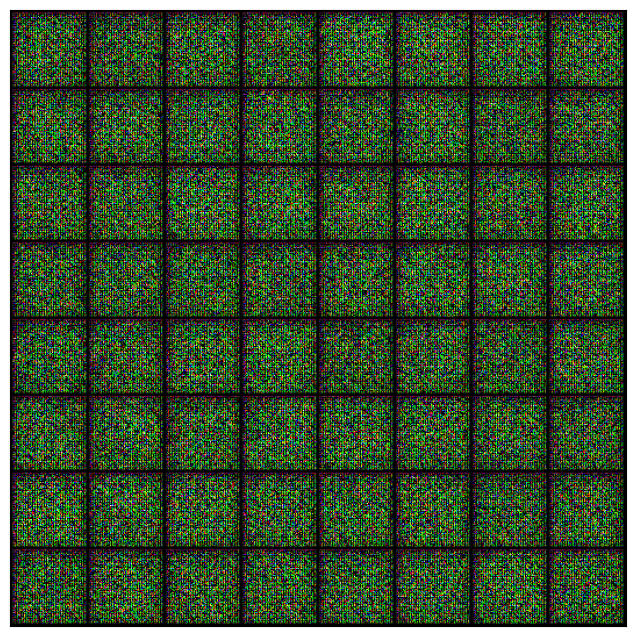

In [ ]:
starter_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, starter_latent)

Training the model for 15 epochs with a learning rate of 0.002

In [ ]:
history = fit(15,0.002)

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 1 / 15  loss_g:  (4.477685928344727, 0.021009698510169983) loss_d:  2.156935691833496 real score: 0.8236938118934631 fake_score: 0.7017234563827515
Saving generated-images-0000.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 2 / 15  loss_g:  (6.841541767120361, 0.0019493588479235768) loss_d:  1.8085054159164429 real score: 0.9634870886802673 fake_score: 0.7826964259147644
Saving generated-images-0001.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 3 / 15  loss_g:  (4.616608619689941, 0.017437472939491272) loss_d:  0.5982028245925903 real score: 0.8440656661987305 fake_score: 0.29474565386772156
Saving generated-images-0002.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 4 / 15  loss_g:  (2.6834568977355957, 0.0881088376045227) loss_d:  0.9333070516586304 real score: 0.6575865149497986 fake_score: 0.35738521814346313
Saving generated-images-0003.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 5 / 15  loss_g:  (2.697620153427124, 0.09473519772291183) loss_d:  0.9459831714630127 real score: 0.6262320876121521 fake_score: 0.3125856816768646
Saving generated-images-0004.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 6 / 15  loss_g:  (4.783656597137451, 0.022998973727226257) loss_d:  0.9088256359100342 real score: 0.9398885369300842 fake_score: 0.5041642785072327
Saving generated-images-0005.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 7 / 15  loss_g:  (4.674219131469727, 0.013896312564611435) loss_d:  0.9799851179122925 real score: 0.912176787853241 fake_score: 0.5393374562263489
Saving generated-images-0006.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 8 / 15  loss_g:  (3.071474552154541, 0.07686299085617065) loss_d:  0.7070935964584351 real score: 0.7437030076980591 fake_score: 0.2753000855445862
Saving generated-images-0007.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 9 / 15  loss_g:  (4.364749908447266, 0.022387482225894928) loss_d:  0.8575752973556519 real score: 0.8906762599945068 fake_score: 0.47829392552375793
Saving generated-images-0008.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 10 / 15  loss_g:  (2.6604955196380615, 0.10928158462047577) loss_d:  0.6338282227516174 real score: 0.6897799372673035 fake_score: 0.16418194770812988
Saving generated-images-0009.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 11 / 15  loss_g:  (3.4811089038848877, 0.05017867684364319) loss_d:  0.5108816027641296 real score: 0.8489134907722473 fake_score: 0.2508436143398285
Saving generated-images-0010.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 12 / 15  loss_g:  (3.814833164215088, 0.048022739589214325) loss_d:  0.651522159576416 real score: 0.829643189907074 fake_score: 0.29237186908721924
Saving generated-images-0011.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 13 / 15  loss_g:  (3.5647876262664795, 0.07020855695009232) loss_d:  0.8654488921165466 real score: 0.5363536477088928 fake_score: 0.0363694429397583
Saving generated-images-0012.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 14 / 15  loss_g:  (5.4037652015686035, 0.010141953825950623) loss_d:  0.5385921001434326 real score: 0.826354444026947 fake_score: 0.24060940742492676
Saving generated-images-0013.png


  0%|          | 0/152 [00:00<?, ?it/s]

Epoch 15 / 15  loss_g:  (4.723862648010254, 0.02178523689508438) loss_d:  0.5637032389640808 real score: 0.8898985981941223 fake_score: 0.3100288510322571
Saving generated-images-0014.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Metrics logged.


Let's look at the results of the generator at different stages (epochs) of the training.

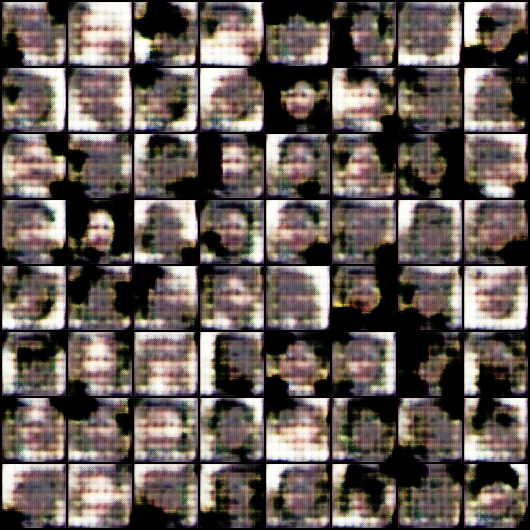

In [ ]:
# Save the model checkpoints
torch.save(gen.state_dict(), 'G.pth')
torch.save(disc.state_dict(), 'D.pth')
from IPython.display import Image
#Image('/generated-images/generated-images-0001.png')
Image(os.path.join(dir_name, 'generated-images-0001.png'))

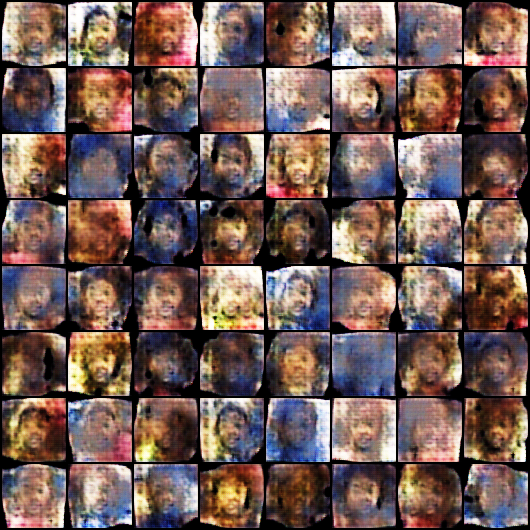

In [ ]:
Image(os.path.join(dir_name, 'generated-images-0005.png'))

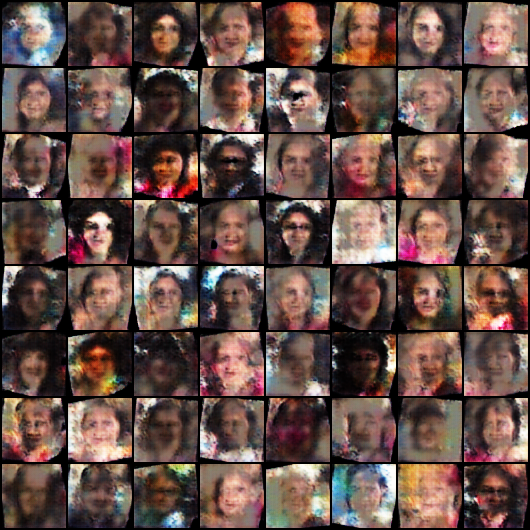

In [ ]:
Image(os.path.join(dir_name, 'generated-images-0010.png'))

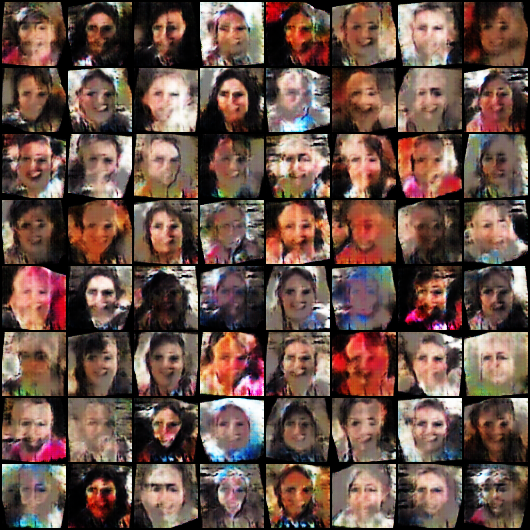

In [ ]:
Image(os.path.join(dir_name, 'generated-images-0014.png'))

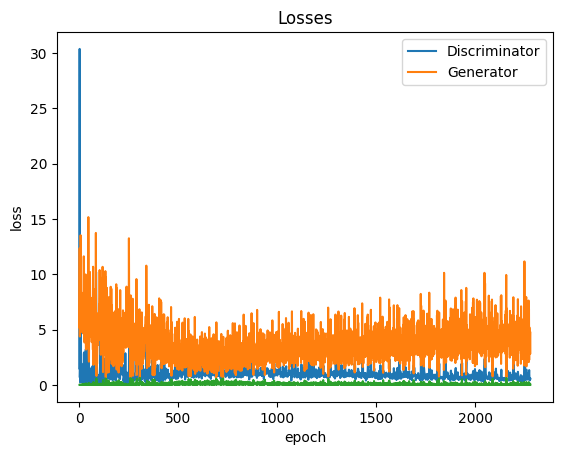

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

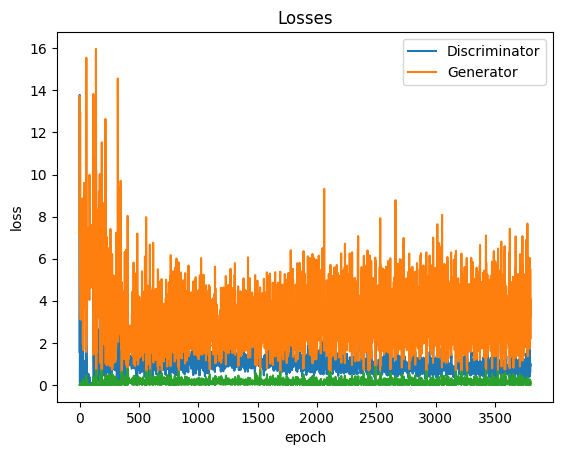

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Conclusions :

Writing the above code to create a generative adversial network helped me learn a lot along the process.The overall procedure looked something like this :

1. Downloading the dataset, extracting the individual images and loading them onto the training and validation data loader.
2.Setting the default device as a GPU
3. Creating the discriminator and generator networks. The simple 512-256-128-64-3 architecture is pretty straightforward and seems to be working. LeakyRelu (0.002) has been used to introduce non-linearity in the discriminator network.
4. In the training process, we train the discriminator to identify images generated by the generator as fake and those fed through the dataloader as real.
5. When training the generator , we pass the generated images through the discriminator except the this time the targets are set as 1 i.e real. This helps train the generator to fool the discriminator better.
6. The Adam Optimizer has been used above.
7. We then define a helper function save_samples() to save the images produced by the generator.
8. Finally we run a few training loops and record a final real score and fake score.
9. Using the Image function, we display the images created by the generator in the 1st, 5th and 10th iteration.

GANs work on a very fascinating principle where it becomes very important for both the generator and the discriminator to work together in tandem.If either one of the two gets too good the model would fail. This delicate balance makes it fun to watch and experiment with GANs.

I myself plan to move on to more projects involving GANs and other popular libraries like Keras , TensorFlow and TorchGAN.

In [ ]:
jovian.commit(project='project', environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
